In [1]:
from dotenv import load_dotenv, find_dotenv

# Load the API keys from .env
load_dotenv(find_dotenv(), override=True)

from src.utils.state import GraphState

from langgraph.graph import StateGraph, END
from IPython.display import Image, display

from src.utils.nodes import (web_search, 
                             retrieve, 
                             grade_documents, 
                             generate_response, 
                             route_question,
                             decide_to_generate_response,
                             check_hallucinations)

e:\Github Repositories\AI-Research-Assistant-Local-RAG-Agent-Ollama\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


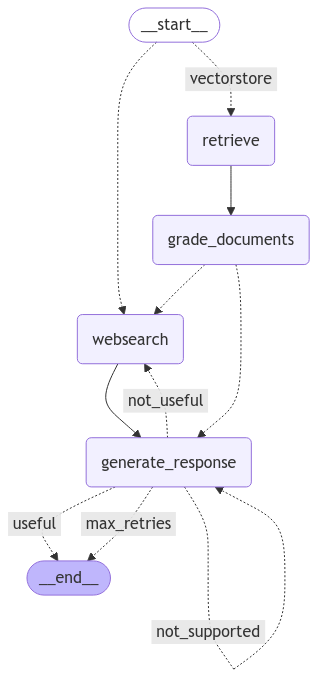

In [2]:
workflow = StateGraph(GraphState)

workflow.add_node("websearch", web_search)  
workflow.add_node("retrieve", retrieve) 
workflow.add_node("grade_documents", grade_documents)  
workflow.add_node("generate_response", generate_response) 

workflow.set_conditional_entry_point(
    route_question,
    {
        "websearch": "websearch",
        "vectorstore": "retrieve",
    },
)
workflow.add_edge("websearch", "generate_response")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate_response,
    {
        "websearch": "websearch",
        "generate_response": "generate_response",
    },
)
workflow.add_conditional_edges(
    "generate_response",
    check_hallucinations,
    {
        "not_supported": "generate_response",
        "useful": END,
        "not_useful": "websearch",
        "max_retries": END,
    },
)

graph = workflow.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [3]:
inputs = {"question": "What is rag really?", "max_retries": 3}
for event in graph.stream(inputs, stream_mode="values"):
    print(event)

---- route_question ----
---- route to: vectorstore ----
{'question': 'What is rag really?', 'max_retries': 3}
---- retrieve ----
{'question': 'What is rag really?', 'documents': [Document(metadata={'Authors': 'Daniel Fleischer, Moshe Berchansky, Moshe Wasserblat, Peter Izsak', 'Published': '2024-08-05', 'Summary': 'Implementing Retrieval-Augmented Generation (RAG) systems is inherently\ncomplex, requiring deep understanding of data, use cases, and intricate design\ndecisions. Additionally, evaluating these systems presents significant\nchallenges, necessitating assessment of both retrieval accuracy and generative\nquality through a multi-faceted approach. We introduce RAG Foundry, an\nopen-source framework for augmenting large language models for RAG use cases.\nRAG Foundry integrates data creation, training, inference and evaluation into a\nsingle workflow, facilitating the creation of data-augmented datasets for\ntraining and evaluating large language models in RAG settings. This in

In [ ]:
event

{'question': 'What is rag really?',
 'response': 'RAG (Retrieval-Augmented Generation) is a natural language processing technique that enhances text generation by integrating information retrieved from a large corpus of documents. It combines retrieval models with generative models to produce accurate and contextually relevant outputs, allowing for the sourcing of specific information during text generation. By leveraging external data sources, RAG enables more informative and helpful responses in various applications, such as customer support and content creation.',
 'documents': [Document(metadata={'Authors': 'Daniel Fleischer, Moshe Berchansky, Moshe Wasserblat, Peter Izsak', 'Published': '2024-08-05', 'Summary': 'Implementing Retrieval-Augmented Generation (RAG) systems is inherently\ncomplex, requiring deep understanding of data, use cases, and intricate design\ndecisions. Additionally, evaluating these systems presents significant\nchallenges, necessitating assessment of both ret

: 